# Konvolutivni slojevi verzija 3

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import torch
from tensorflow.keras.callbacks import ModelCheckpoint

2024-08-22 11:04:36.978304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 11:04:37.048162: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 11:04:37.067012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 11:04:37.195711: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 11:04:38.093229: W tensorflow/compiler/tf2

Lokacija dataset-a

In [2]:
dataset_path = "../data_set/casting_data/casting_data"
classes = ["ok_front", "def_front"]

Inicijalizacija lista za cuvanje podataka


In [3]:
data = []
labels = []

Ucitavanje slika kroz klase


In [4]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "train", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
        img = cv2.resize(img, (128, 128))  # Resize to 128x128
        data.append(img)
        labels.append(classes.index(class_name))

Konvertovanje listi u numpy


In [5]:
data = np.array(data) / 255.0  # Normalize pixel values
data = np.expand_dims(data, axis=-1)
labels = np.array(labels)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)


ImageDataGenerator za data augmentation


In [7]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train)

CNN model sa konvolutivnim slojevima

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    
    Dense(len(classes), activation='softmax')
])

/home/teki/Documents/sd3/.master/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1724317484.375753    6905 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-22 11:04:44.382300: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libr

In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [11]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val),
                    epochs=50, callbacks=[early_stopping])


Epoch 1/50


/home/teki/Documents/sd3/.master/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


166/166 ━━━━━━━━━━━━━━━━━━━━ 38s 220ms/step - accuracy: 0.5572 - loss: 0.7060 - val_accuracy: 0.5614 - val_loss: 0.6793
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 36s 213ms/step - accuracy: 0.5888 - loss: 0.6744 - val_accuracy: 0.6420 - val_loss: 0.6250
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 212ms/step - accuracy: 0.7061 - loss: 0.5896 - val_accuracy: 0.5456 - val_loss: 0.7214
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 211ms/step - accuracy: 0.7947 - loss: 0.4642 - val_accuracy: 0.5923 - val_loss: 0.7596
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 210ms/step - accuracy: 0.8714 - loss: 0.3271 - val_accuracy: 0.5727 - val_loss: 1.0344
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 209ms/step - accuracy: 0.9000 - loss: 0.2842 - val_accuracy: 0.8410 - val_loss: 0.4046
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 210ms/step - accuracy: 0.9092 - loss: 0.2519 - val_accuracy: 0.6368 - val_loss: 1.0296
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 210ms/step - accuracy: 0.9092 - loss: 0.2309 - val

In [12]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

Evaluacija modela na test skupu

In [13]:
test_data = []
test_labels = []

In [14]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "test", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))
        test_data.append(img)
        test_labels.append(classes.index(class_name))

test_data = np.array(test_data) / 255.0
test_data = np.expand_dims(test_data, axis=-1)
test_labels = np.array(test_labels)

In [15]:
# Model evaluation
test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)
print(f'Test greska: {test_loss:.4f}, Test tačnost: {test_accuracy:.4f}')


Test greska: 0.3062, Test tačnost: 0.8881


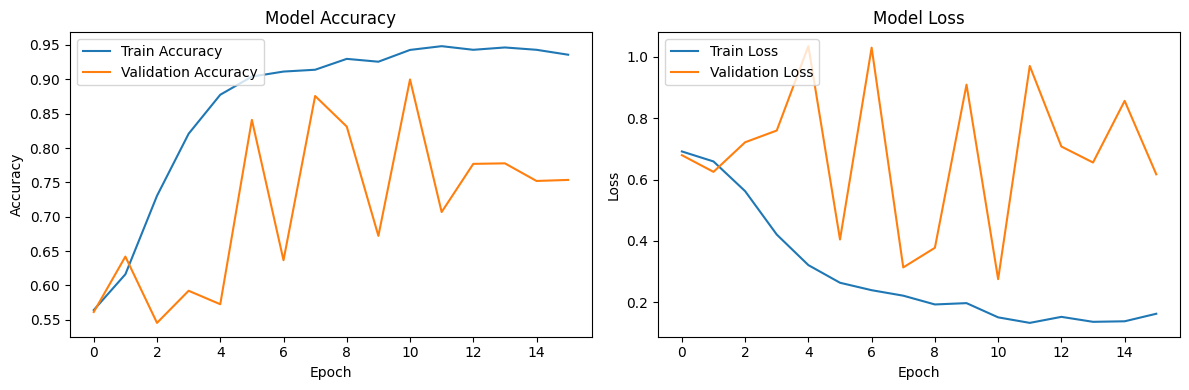

In [16]:
# Plotting training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Classification report

In [17]:
# Classification report
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
report = classification_report(test_labels, predicted_classes, target_names=classes)
print("Classification Report:")
print(report)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Classification Report:
              precision    recall  f1-score   support

    ok_front       0.77      0.98      0.87       262
   def_front       0.99      0.83      0.90       453

    accuracy                           0.89       715
   macro avg       0.88      0.91      0.88       715
weighted avg       0.91      0.89      0.89       715

